In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import datetime 
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/albedo/home/pscholz/tripyview


In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 256                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/data_errie_rohit/mesh/NG5/'
save_path         = '/albedo/work/user/pscholz/data_errie_rohit/' # None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#_____________________________________________________________________________________
# set datapath
input_paths= list()
input_paths.append('/albedo/work/user/pscholz/data_errie_rohit/')

input_names   = list()
input_names.append('Phase1-CTL-FESOM')

#_____________________________________________________________________________________
# set run infos
vname      = 'amoc'  # gmoc, amoc, ipmoc, imoc, pmoc
year       = [1950, 1969]

mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True
do_netcdf         = True
do_info           = False

In [3]:
# start parallel dask client
safety = 0.3
if do_parallel and not client_runs:
    from dask.distributed import Client
    
    #import dask
    #dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem*(1.0-safety)/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem*(1.0-safety)/parallel_nprc))
    client_runs = True
    display(client)

 --> memory_limit: 3.733 GB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 48
Total threads: 48,Total memory: 166.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39775,Workers: 48
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 166.88 GiB
Comm: tcp://127.0.0.1:35045,Total threads: 1
Dashboard: http://127.0.0.1:34435/status,Memory: 3.48 GiB
Nanny: tcp://127.0.0.1:44309,


## > Load mesh:

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

#______________________________________________________________________________________________________        
if save_path is not None:
    if not os.path.isdir(save_path): os.makedirs(save_path)

#______________________________________________________________________________________________________
chunks ={'time'   :'auto', 
         'nod2'   :'auto', 
         'elem'   :'auto', 
         'ncells' :'auto', 
         'ntriags':'auto', }   

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/data_errie_rohit/mesh/NG5
 > load  *.jlib file: tripyview_fesom2_NG5_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/rohit_errie/mesh/NG5
 > id              = NG5
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 7402886
 > #elem           = 14741520
 > #lvls           = 70
___________________________________________


##  > Compute: MOC vs. time
- compute annual mean MOC from monthly mean FESOM1.4 AWI-CM-1-1-HR CMIP6 vertical velocities (var:wo)

In [5]:
#______________________________________________________________________________________________________
ts     = clock.time()
zmoc_t = xr.Dataset()
for jj, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath)

    #__________________________________________________________________________________________________
    # loop over year to open 10-year bundled files 
    t1s = clock.time()
    for yr in range(year[0], year[1]+1):
        #______________________________________________________________________________________________
        # create rohit filename path
        print(' --> open files: {:4d} '.format(yr), end='')
        filepath = list()
        for auxmon in range(1,12+1):
            fname       = 'fesom_avg_wo_{:4d}{:02d}_monthly-NG5.nc'.format(yr, auxmon)
            filepath.append(os.path.join(datapath+'/{:4d}/native/monthly/'.format(yr), fname))
        del auxmon    
        
        #______________________________________________________________________________________________
        # load cmip6 filename path
        data = tpv.load_data_fesom2(mesh, filepath, do_filename=True, do_multiio=True, do_tarithm=None, do_zarithm=None,
                                vname='wo', year=year, mon=None, day=None, record=None, chunks=chunks,
                                depth=depth, descript=descript, do_info=False, do_parallel=do_parallel)
        data = data.rename({list(data.data_vars)[0]:'w'})
        
        #______________________________________________________________________________________________
        # compute time mean --> data are monthly mean, AMOC usually computed on annual mean
        # --> annual means can be computed with do_arithm='mean'
        
        #______________________________________________________________________________________________
        # compute zmoc    
        print('--> comp. {:s} '.format(vname), end='')
        zmoc = tpv.calc_zmoc(mesh, data, dlat=0.5, which_moc=vname, do_info=do_info, do_checkbasin=False, do_onelem=False, diagpath=False, 
                             do_load=True, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        
        del(data)
        
        #______________________________________________________________________________________________
        # accumulate to zmoc over time
        zmoc_t = xr.merge([zmoc_t, zmoc], combine_attrs='drop_conflicts') #no_conflicts
        del(zmoc)
        
        #______________________________________________________________________________________________
        t1e = clock.time()
        print('--> elapsed time: {:3.3f} sec. '.format(t1e-t1s))
        t1s = t1e
    
    #__________________________________________________________________________________________________
    # save to netcdf
    if do_netcdf and save_path is not None:
        auxtime   = zmoc_t['time.year'].values
        auxrun    = descript.replace(' ','_').lower()
        sfname    = f'{vname}_vs_lat_vs_depth_vs_t_{auxrun}_y{auxtime[0]}-{auxtime[-1]}.nc'
        # sfilepath = os.path.join(datapath, sfname)
        sfilepath = os.path.join(save_path, sfname)
        print(' --> save zmoc_t to file:', sfname)
        zmoc_t.to_netcdf(path=sfilepath, mode='w')
    
print(' --> tot. elapsed time: {:.3f} min.'.format((clock.time()-ts)/60))

/albedo/work/user/pscholz/data_errie_rohit/
 --> open files: 1950 --> comp. amoc --> elapsed time: 60.337 sec. 
 --> open files: 1951 --> comp. amoc --> elapsed time: 51.964 sec. 
 --> open files: 1952 --> comp. amoc --> elapsed time: 51.811 sec. 
 --> open files: 1953 --> comp. amoc --> elapsed time: 51.568 sec. 
 --> open files: 1954 --> comp. amoc --> elapsed time: 51.529 sec. 
 --> open files: 1955 --> comp. amoc --> elapsed time: 52.090 sec. 
 --> open files: 1956 --> comp. amoc --> elapsed time: 52.958 sec. 
 --> open files: 1957 --> comp. amoc --> elapsed time: 54.665 sec. 
 --> open files: 1958 --> comp. amoc --> elapsed time: 53.894 sec. 
 --> open files: 1959 --> comp. amoc --> elapsed time: 54.390 sec. 
 --> open files: 1960 --> comp. amoc --> elapsed time: 53.245 sec. 
 --> open files: 1961 --> comp. amoc --> elapsed time: 53.185 sec. 
 --> open files: 1962 --> comp. amoc --> elapsed time: 53.838 sec. 
 --> open files: 1963 --> comp. amoc --> elapsed time: 53.298 sec. 
 -->

##  > Plot: mean MOC 

--> histo: cmin, cmax =  -3.2876787185668945 19.343502044677734
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-3.29), 'cmax': np.float64(19.34), 'cmap': <matplotlib.colors.ListedColormap object at 0x15552a881eb0>, 'clevel': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]), 'clab': array([-4.,  0.,  4.,  8., 12., 16., 20.])}
 > save figure: /albedo/work/user/pscholz/data_errie_rohit/amoc_phase1-ctl-fesom_y1950-1969.png


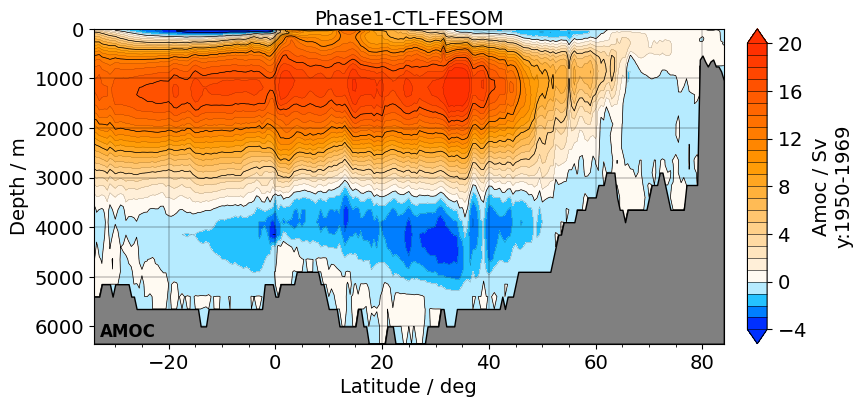

In [8]:
#__________________________________________________________________________________________________
# do save filename path
spath     = save_path
svname    = vname
sfpath    = None
which_run = descript.replace(' ','_').lower()
auxtime   = zmoc_t['time.year'].values
slabel    = f'y{auxtime[0]}-{auxtime[-1]}'
nrow0, ncol0= 1,1

if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, which_run ,slabel, sfmt)) )
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, [zmoc_t.mean(dim='time', keep_attrs=True)], nrow=nrow0, ncol=ncol0, cinfo=cinfo0, 
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                    do_save=sfpath, save_dpi=save_dpi )    

## > Compute: MOC time series @ latitude

In [10]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # depth range definition for upper/lower cell

#____________________________________________________________________________________________________
# compute time-series
if  vname == 'ipmoc' or vname == 'pmoc':
    zmoc_maxatlat = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
    zmoc_maxatlat['zmoc_lcell'].attrs['description'] = 'minimum PMOC between a depth of {:f}m and {:f}m'.format(zdeflc[0], zdeflc[1])
    str_sel = 'min'
    
elif vname == 'amoc' or vname == 'aamoc':
    zmoc_ucell  = zmoc_t.where((zmoc_t['depth']>=zdefuc[0]) & (zmoc_t['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_ucell'})
    zmoc_ucell['zmoc_ucell'].attrs['description'] = 'maximum AMOC between a depth of {:f}m and {:f}m'.format(zdefuc[0], zdefuc[1])
    
    zmoc_lcell  = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
    zmoc_lcell['zmoc_lcell'].attrs['description'] = 'minimum AMOC between a depth of {:f}m and {:f}m'.format(zdeflc[0], zdeflc[1])
    
    zmoc_maxatlat = xr.merge([zmoc_ucell, zmoc_lcell], compat='minimal' )
    str_sel = 'maxmin'
    del(zmoc_ucell, zmoc_lcell)

#_____________________________________________________________________________________________________
# save to netcdf
if (do_netcdf) and (save_path is not None) and (vname in ['amoc', 'aamoc', 'ipmoc', 'pmoc']):
    auxtime   = zmoc_t['time.year'].values
    sfname    = f'{vname}_{str_sel}_vs_lat_vs_t_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
    sfilepath = os.path.join(save_path, sfname)
    print(' --> save max. zmoc_t @ lat. to file:', sfname)
    zmoc_maxatlat.to_netcdf(path=sfilepath, mode='w')        

 --> save max. zmoc_t @ lat. to file: amoc_maxmin_vs_lat_vs_t_phase1-ctl-fesom_y1950-1969.nc


## > Plot: MOC time-series @ latitude

 > save figure: /albedo/work/user/pscholz/data_errie_rohit/amoc_phase1-ctl-fesom_ucell_y1950-1969.png
 > save figure: /albedo/work/user/pscholz/data_errie_rohit/amoc_phase1-ctl-fesom_lcell_y1950-1969.png


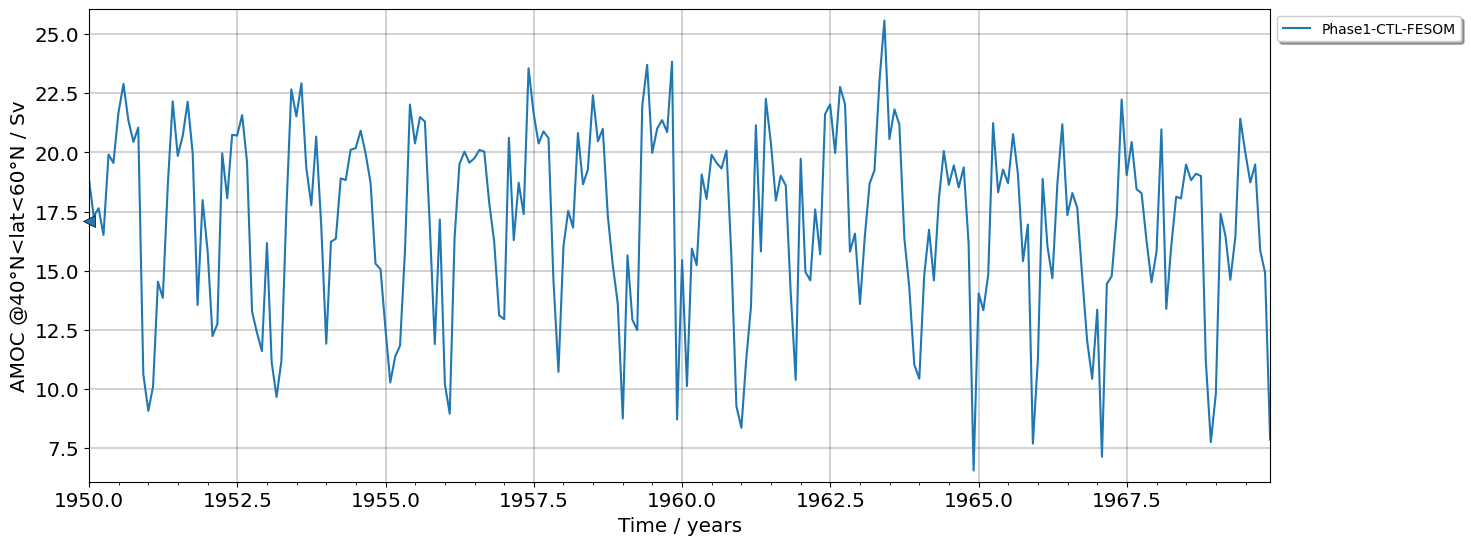

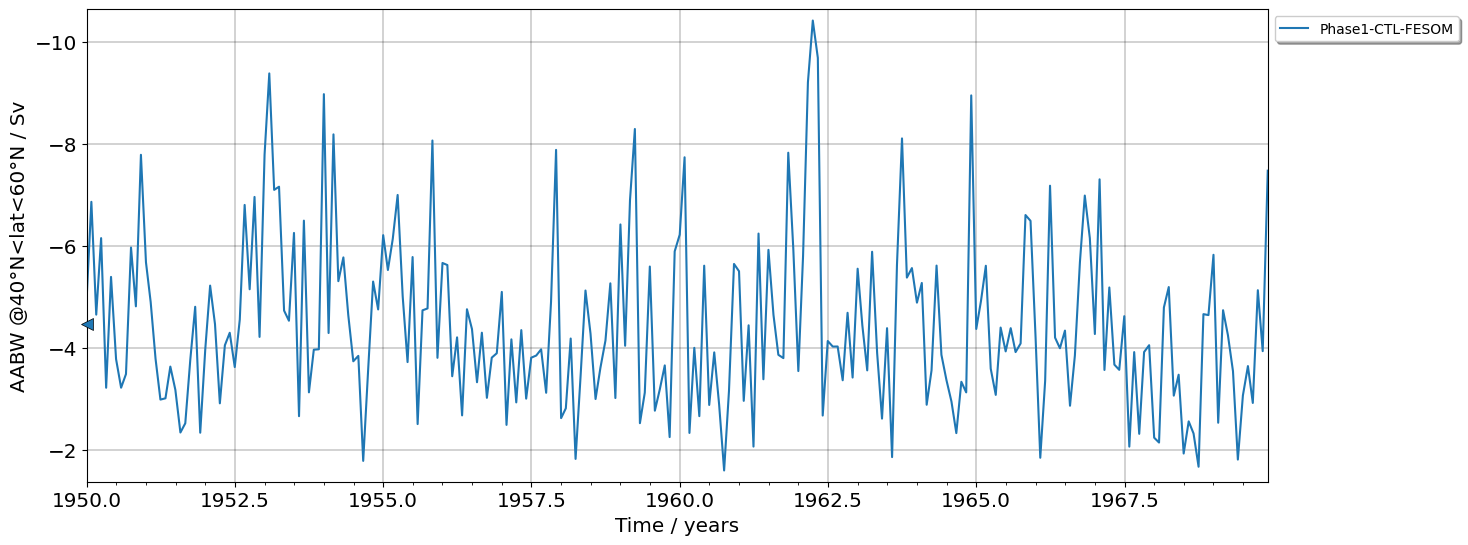

In [11]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
which_lat = ['max'] # 'max' # 'max', 26.0

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_nadw','zmoc_ucell']:
                data_lat = zmoc_maxatlat[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                lat_list.append([data_lat])        
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = vname #list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, which_run, 'ucell' ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':3}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )

    
    
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_aabw','zmoc_lcell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                data_lat[var].attrs['short_name'] = 'AABW'
                data_lat[var].attrs['long_name']  = 'AABW'
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = vname #list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, which_run, 'lcell' ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':3}) ,
                            grid_opt   = dict({'do_yinv':True}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )